# HLMA 408: Gaussiennes bivariées et visualisation interactive

***
> __Auteur__: Joseph Salmon <joseph.salmon@umontpellier.fr>

Ce widget permet d'investiguer l'impact de la matrice de variance-covariance sur une loi normalle bi-dimensionnelle.

On fixe le paramètre de centrage par simplicité à $(0, 0)$. 

La covariance est paramètrée ici de la manière suivante (décomposition spectrale):

$$\Sigma = \begin{pmatrix}\cos(\theta) & - \sin(\theta)\\  \sin(\theta)& \cos(\theta)\end{pmatrix} \cdot
\begin{pmatrix}\sigma_1 & 0\\ 0 & \sigma_2 \end{pmatrix}
\begin{pmatrix}\cos(\theta) &\sin(\theta)\\  -\sin(\theta)& \cos(\theta)\end{pmatrix}
$$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm, multivariate_normal
import ipywidgets  # ipywidgets>=7.5

In [2]:
%matplotlib widget


## Visualisation, densité gaussienne (en dimension 2)

In [3]:
def make_box_layout():
    return ipywidgets.Layout(
        border='solid 1px black',
        margin='0px 10px 10px 0px',
        padding='5px 5px 5px 5px',
    )

In [4]:
def covmat_to_scalar(Sigma):
    """Convert covariance matrix to scalars."""
    sigmax = np.sqrt(Sigma[0, 0])
    sigmay = np.sqrt(Sigma[1, 1])
    sigmaxy = Sigma[1, 0]
    return sigmax, sigmay, sigmaxy

@njit()
def angle_scalar_to_covmat(theta, sig1, sig2):
    """Inverse function of the previous one."""
    rotation = np.zeros((2, 2))
    rotation[0, 0] = np.cos(theta)
    rotation[1, 0] = np.sin(theta)
    rotation[0, 1] = -np.sin(theta)
    rotation[1, 1] = np.cos(theta)
    Sigma = rotation.dot(np.diag([sig1 ** 2, sig2 ** 2])).dot(rotation.T)
    #Sigma = rotation.dot(np.eye(2) * np.array([sig1 ** 2, sig2 ** 2])).dot(rotation.T)
    return Sigma

In [11]:
def pdf_2d(Xg, Yg, theta=2*np.pi/3, sig1=4, sig2=2):
    Sigma = angle_scalar_to_covmat(theta, sig1, sig2)
    rv = multivariate_normal([0, 0], Sigma)
    pos = np.empty(Xg.shape + (2,))
    pos[:, :, 0] = Xg
    pos[:, :, 1] = Yg
    Z = rv.pdf(pos)
    return Z

In [12]:
class RandomWidgetContinu(ipywidgets.HBox):

    def __init__(self):
        super().__init__()
        output = ipywidgets.Output()
        
        # Init default values for display
        self.theta = 45
        self.theta_radian = self.theta / 180.0 * np.pi  # convertion en radian
        self.sig1 = 2
        self.sig2 = 4
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)


        # Init plot (1, 2) for subplots
        with output:
            self.fig, self.ax = plt.subplots(1, 2, sharex=True, constrained_layout=True, figsize=(6.8, 4.4),
                                             num='Gaussiennes: Densité et tirages aléatoires 2D')        
        self.fig.canvas.toolbar_visible = False

        # Bornes d'affichage
        xyr = 5
        self.xranges = (-xyr, xyr)
        self.yranges = (-xyr, xyr)
        
        # Displays the variance-covariance matrix
        self.my_text_up = self.ax[1].text(-1, xyr+1.5, '{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]),
                                          size=8, color='black')
        self.my_text_down = self.ax[1].text(-1, xyr+.5, '{sig21:6.2f}   {sig22:6.2f}'.format( sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]),
                                            size=8, color='black')
        self.ax[1].text(-2.5, xyr+1, '$\Sigma = $', size=14, color='black')
        self.ax[1].text(-1.5, xyr+.5, '$[$', size=50, color='black')
        self.ax[1].text(1.5, xyr+.5, '$]$', size=50, color='black')        
        
        # set 3d plot : density
        step = 200
        self.xx = np.linspace(-self.xranges[0], -self.xranges[1], step)
        self.yy = np.linspace(-self.yranges[0], -self.yranges[1], step)
        self.Xg, self.Yg = np.meshgrid(self.xx, self.yy)
        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.ax[0].remove()
        self.ax[0] = self.fig.add_subplot(1, 2, 1, projection='3d')
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', linewidth=0.1, rstride=3, cstride=3, alpha=0.95, lw=0.5, edgecolors='k')
        self.ax[0].set_zticks([])
        self.ax[0].set_xlabel(r'$x$')
        self.ax[0].set_ylabel(r'$y$')
        self.ax[0].set_xlim(self.xranges)
        self.ax[0].set_ylim(self.yranges)
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        ####
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])
        ####
        
        # set 2d plot : a sample
        self.n_samples = 200
        self.samples = np.random.multivariate_normal([0, 0], self.Sigma, self.n_samples)
        self.size = 5
        self.initial_color = '#1a60e1'
        self.params = dict(color=self.initial_color, alpha=0.50, linewidth=0.2)  # , edgecolor="black"

        self.ax[1].autoscale(False)  # To avoid that the scatter changes limits
        self.ax[1].set_xlabel(r'$x$')
        self.ax[1].set_ylabel(r'$y$', rotation=0)
        self.ax[1].yaxis.set_label_position("right")
        self.ax[1].set_yticks(np.arange(self.xranges[0], self.xranges[1] + 1, 5))
        self.ax[1].set_xticks(np.arange(self.yranges[0], self.yranges[1] + 1, 5))
        
        # -> lignes de niveaux
        self.cdf = self.ax[1].contourf(self.xx, self.yy, Z, levels=12, cmap='Oranges')
        self.cdf_bis = self.ax[1].contour(self.xx, self.yy, Z, levels=12, linewidths=0.5, colors=['k'])
        # -> nuage de points
        self.points = self.ax[1].scatter(self.samples[:, 0], self.samples[:, 1], alpha=0.5, color='#4cb7ff',
                                         s=14, zorder=2,  edgecolors='black', linewidth=0.3)


        # define widgets
        style = {'description_width': '40px'}
        layout = {'width': '215px'}
        n_samples_slider = ipywidgets.IntSlider(value=self.n_samples, description="$n$",
                                                style=style, layout=layout, min=1, max=501, step=10)
        theta_slider = ipywidgets.FloatSlider(value=self.theta, description='$\\theta$',
                                              style=style, layout=layout, min=0, max=360, step=10)
        sig1_slider = ipywidgets.FloatSlider(value=self.sig1, description='$\sigma_1$',
                                             style=style, layout=layout,min=0.5, max=5, step=0.5)
        sig2_slider = ipywidgets.FloatSlider(value=self.sig2, description='$\sigma_2$',
                                             style=style, layout=layout, min=0.5, max=5, step=0.5)
        resample_button = ipywidgets.Button(description="Nouveau tirage",style=style, layout=layout) 
        # Slide box
        controls = ipywidgets.VBox([n_samples_slider, theta_slider,
                                    sig1_slider, sig2_slider, resample_button])

        controls.layout = make_box_layout()
        out_box = ipywidgets.Box([output])
        output.layout = make_box_layout()


        # A Afficher
        n_samples_slider.observe(self.update_n_samples, 'value')
        theta_slider.observe(self.update_theta, 'value')
        sig1_slider.observe(self.update_sig1, 'value')
        sig2_slider.observe(self.update_sig2, 'value')
        resample_button.on_click(self.update_resample_button)

        self.children = [controls, output]





    def update_theta(self, change):
        """Evolution with the theta parameter."""
        self.theta = change.new
        self.theta_radian = self.theta / 180.0 * np.pi  # convertion en radian
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)
        self.samples = np.random.multivariate_normal([0, 0], self.Sigma, self.n_samples)       

        self.my_text_up.set_text('{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]))
        self.my_text_down.set_text('{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]))
        
        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.pdf.remove()
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', rstride=3, cstride=3, 
                                           alpha=0.95, lw=0.5, edgecolors='k') 

        for coll in self.cdf.collections:
            coll.remove()
        self.cdf = self.ax[1].contourf(self.xx, self.yy, Z, levels=12, cmap='Oranges')
        for coll in self.cdf_bis.collections:
            coll.remove()
        self.cdf_bis = self.ax[1].contour(self.xx, self.yy, Z, levels=12, linewidths=0.5, colors=['k'])
        ##
        for coll in self.pdf1.collections:
            coll.remove()
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])
        ##
        self.points.set_offsets(np.c_[[self.samples[:, 0], self.samples[:, 1]]].T)
        self.fig.canvas.draw()


    def update_sig1(self, change):
        """Evolution with the sigma1 parameter."""
        self.sig1 = change.new
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)
        self.samples = np.random.multivariate_normal([0, 0], self.Sigma, self.n_samples)
        
        self.my_text_up.set_text('{sig11:6.2f}   {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]))
        self.my_text_down.set_text('{sig21:6.2f}   {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]))

        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.pdf.remove()
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', rstride=3, cstride=3,
                                           alpha=0.95, lw=0.5, edgecolors='k') 
        for coll in self.cdf.collections:
            coll.remove()
        self.cdf = self.ax[1].contourf(self.xx, self.yy, Z, levels=12, cmap='Oranges')
        for coll in self.cdf_bis.collections:
            coll.remove()
        self.cdf_bis = self.ax[1].contour(self.xx, self.yy, Z, levels=12, linewidths=0.5, colors=['k'])
        ##
        for coll in self.pdf1.collections:
            coll.remove()
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])
        ##
        self.points.set_offsets(np.c_[[self.samples[:, 0], self.samples[:, 1]]].T)
        self.fig.canvas.draw()

        
    def update_sig2(self, change):
        """Evolution with the sigma1 parameter."""
        self.sig2 = change.new
        self.Sigma = angle_scalar_to_covmat(self.theta_radian, self.sig1, self.sig2)
        self.samples = np.random.multivariate_normal([0, 0], self.Sigma, self.n_samples)
        self.my_text_up.set_text('{sig11:6.2f}    {sig12:6.2f}'.format(sig11=self.Sigma[0, 0], sig12=self.Sigma[1, 0]))
        self.my_text_down.set_text('{sig21:6.2f}    {sig22:6.2f}'.format(sig21=self.Sigma[0, 1], sig22=self.Sigma[1, 1]))
 
        Z = pdf_2d(self.Xg, self.Yg, theta=self.theta_radian, sig1=self.sig1, sig2=self.sig2)
        self.pdf.remove()
        self.pdf = self.ax[0].plot_surface(self.Xg, self.Yg, Z, cmap='Oranges', rstride=3, cstride=3, alpha=0.95, lw=0.5, edgecolors='k') 
        for coll in self.cdf.collections:
            coll.remove()
        self.cdf = self.ax[1].contourf(self.xx, self.yy, Z, levels=12, cmap='Oranges')
        for coll in self.cdf_bis.collections:
            coll.remove() 
        self.cdf_bis = self.ax[1].contour(self.xx, self.yy, Z, levels=12, linewidths=0.5, colors=['k'])
        
        ##
        for coll in self.pdf1.collections:
            coll.remove()
        self.ax[0].set_zlim((-0.2, .75*np.max(Z)))
        self.pdf1 = self.ax[0].contourf(self.Xg, self.Yg, Z, offset=-0.2, levels=12, cmap='Oranges')
        self.pdf1 = self.ax[0].contour(self.Xg, self.Yg, Z, offset=-0.2, levels=12, linewidths=0.25, colors=['k'])
        ##
        self.points.set_offsets(np.c_[[self.samples[:, 0], self.samples[:, 1]]].T)
        self.fig.canvas.draw()

        
        
    def update_n_samples(self, change):
        """Evolution with the n_samples parameter."""
        self.n_samples = change.new
        self.samples = np.random.multivariate_normal([0, 0], self.Sigma, self.n_samples)
        self.points.set_offsets(np.c_[[self.samples[:, 0], self.samples[:, 1]]].T)
        self.fig.canvas.draw()

    def line_color(self, change):
        self.initial_color = change.new
        self.pdf.set_color(self.initial_color)
        self.cdf.set_color(self.initial_color)
        self.params['color'] = self.initial_color
        self.points.set_offsets(np.c_[[self.samples, self.y]].T)
        self.points.set_color(self.initial_color)
        self.fig.canvas.draw()

    def update_xrange_slider(self, change):
        self.xranges = change.new
        self.pdf.set_ydata(self.distribution.pdf(self.x, loc=self.mu, scale=self.sigma))
        self.cdf.set_ydata(self.distribution.cdf(self.x, loc=self.mu, scale=self.sigma))
        self.ax[0].set_xlim(self.xranges)
        self.ax[1].set_xlim(self.xranges)
        self.fig.canvas.draw()

    def update_yrange_slider_pdf(self, change):
        self.yranges_pdf = change.new
        self.ax[0].set_ylim(self.yranges_pdf)
        self.fig.canvas.draw()

    def update_text_distribution(self, change):
        self.distribution = distributions_0_dict[change.new]
        self.pdf.set_ydata(self.distribution.pdf(self.x, loc=self.mu, scale=self.sigma))
        self.cdf.set_ydata(self.distribution.cdf(self.x, loc=self.mu, scale=self.sigma))
        self.samples = self.distribution.rvs(size=self.n_samples, loc=self.mu, scale=self.sigma)
        self.points.set_color(self.initial_color)
        self.fig.canvas.draw()

    def update_resample_button(self, change):
        self.samples = np.random.multivariate_normal([0, 0], self.Sigma, self.n_samples)
        self.points.set_offsets(np.c_[[self.samples[:, 0], self.samples[:, 1]]].T)


RandomWidgetContinu(children=(VBox(children=(IntSlider(value=200, description='$n$', layout=Layout(width='215p…

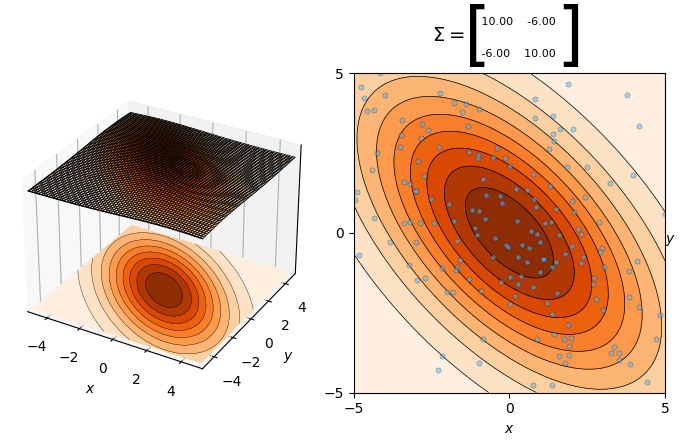

In [13]:
RandomWidgetContinu()